In [2]:
!wget "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"

--2021-09-27 04:22:57--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.124.232.149, 2600:140e:6:ba1::e59, 2600:140e:6:b8d::e59
Connecting to download.microsoft.com (download.microsoft.com)|104.124.232.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   176MB/s    in 4.5s    

2021-09-27 04:23:01 (177 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



In [3]:
!unzip -q "/content/kagglecatsanddogs_3367a.zip"

In [4]:
!ls "PetImages/"

Cat  Dog


In [5]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib 
import os
from tqdm import tqdm 

In [6]:
# No of dog images
len(os.listdir("PetImages/Dog"))

12501

In [7]:
# No of cat images
len(os.listdir("PetImages/Cat"))

12501

In [8]:
DataPath = pathlib.Path("PetImages")
all_paths = DataPath.glob("*/*.jpg")
all_paths

<generator object Path.glob at 0x7f519eef4050>

In [9]:
all_paths = list(all_paths)
all_paths[:10]

[PosixPath('PetImages/Dog/6295.jpg'),
 PosixPath('PetImages/Dog/11400.jpg'),
 PosixPath('PetImages/Dog/7867.jpg'),
 PosixPath('PetImages/Dog/5352.jpg'),
 PosixPath('PetImages/Dog/1042.jpg'),
 PosixPath('PetImages/Dog/1977.jpg'),
 PosixPath('PetImages/Dog/5441.jpg'),
 PosixPath('PetImages/Dog/11853.jpg'),
 PosixPath('PetImages/Dog/11982.jpg'),
 PosixPath('PetImages/Dog/133.jpg')]

In [10]:
all_paths = list(map(lambda x : str(x) , all_paths))
all_paths[:10]

['PetImages/Dog/6295.jpg',
 'PetImages/Dog/11400.jpg',
 'PetImages/Dog/7867.jpg',
 'PetImages/Dog/5352.jpg',
 'PetImages/Dog/1042.jpg',
 'PetImages/Dog/1977.jpg',
 'PetImages/Dog/5441.jpg',
 'PetImages/Dog/11853.jpg',
 'PetImages/Dog/11982.jpg',
 'PetImages/Dog/133.jpg']

In [11]:
from random import shuffle

shuffle(all_paths)
all_paths[:10]

['PetImages/Dog/4288.jpg',
 'PetImages/Cat/5219.jpg',
 'PetImages/Dog/7747.jpg',
 'PetImages/Dog/4296.jpg',
 'PetImages/Dog/1253.jpg',
 'PetImages/Dog/10775.jpg',
 'PetImages/Dog/11206.jpg',
 'PetImages/Cat/1584.jpg',
 'PetImages/Dog/11542.jpg',
 'PetImages/Dog/5432.jpg']

In [12]:
def test_image_quality(all_paths):
    new_all_paths = []
    for path in tqdm(all_paths):
        try :
            image = tf.io.read_file(path)
            image = tf.io.decode_jpeg(image , channels = 3)
        except :
            continue
        new_all_paths.append(path)
    return new_all_paths

all_paths = test_image_quality(all_paths)
all_paths[:10]

100%|██████████| 25000/25000 [00:46<00:00, 540.26it/s]


['PetImages/Dog/4288.jpg',
 'PetImages/Cat/5219.jpg',
 'PetImages/Dog/7747.jpg',
 'PetImages/Dog/4296.jpg',
 'PetImages/Dog/1253.jpg',
 'PetImages/Dog/10775.jpg',
 'PetImages/Dog/11206.jpg',
 'PetImages/Cat/1584.jpg',
 'PetImages/Dog/11542.jpg',
 'PetImages/Dog/5432.jpg']

In [13]:
# Getting their corresponding labels 
def get_label(image_path):
    return image_path.split("/")[-2]

all_labels = list(map(lambda x : get_label(x) , all_paths))
all_labels[:10]

['Dog', 'Cat', 'Dog', 'Dog', 'Dog', 'Dog', 'Dog', 'Cat', 'Dog', 'Dog']

In [14]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
all_labels = Le.fit_transform(all_labels)

all_labels[:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1])

In [15]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(all_paths , all_labels)

In [16]:
# Decode jpeg to tensor
def load_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [17]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 224 
BATCH_SIZE = 128

In [18]:
# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

In [19]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Create a Tensorflow Data Object
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load_image(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    return dataset

In [24]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 500 ms, sys: 7.92 ms, total: 508 ms
Wall time: 520 ms
(128, 224, 224, 3)
(128,)


Dog


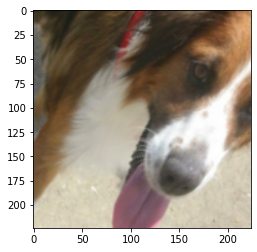

In [25]:
# View a sample Training Image
print(Le.inverse_transform(label)[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [26]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 26.8 ms, sys: 194 µs, total: 27 ms
Wall time: 31.7 ms
(128, 224, 224, 3)
(128,)


Dog


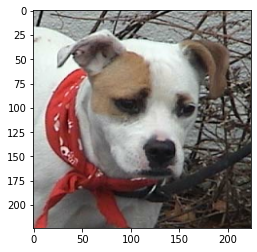

In [27]:
# View a sample Training Image
print(Le.inverse_transform(label)[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [28]:
# Model part 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization , GlobalMaxPool2D

model = Sequential()

# Block 1 
model.add(Conv2D(input_shape=(224 , 224 , 3),  padding='same',filters=32, kernel_size=(7, 7)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(filters=64,  padding='valid', kernel_size=(5, 5)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Block 3 
model.add(Conv2D(filters=128, padding='valid', kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# Block 4 
model.add(Conv2D(filters=256, padding='valid', kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256 , kernel_size=(3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(GlobalMaxPool2D())

model.add(Dense(units=256))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('sigmoid'))

In [29]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      4736      
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 64)      51264     
_________________________________________________________________
activation_1 (Activation)    (None, 108, 108, 64)     

In [30]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [31]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=10,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
)

Epoch 1/10
145/145 [==============================] - 249s 1s/step - loss: 0.8353 - accuracy: 0.6006 - val_loss: 0.6803 - val_accuracy: 0.5705
Epoch 2/10
145/145 [==============================] - 213s 1s/step - loss: 0.5926 - accuracy: 0.6811 - val_loss: 1.1074 - val_accuracy: 0.5068
Epoch 3/10
145/145 [==============================] - 206s 1s/step - loss: 0.5473 - accuracy: 0.7204 - val_loss: 0.8152 - val_accuracy: 0.5365
Epoch 4/10
145/145 [==============================] - 205s 1s/step - loss: 0.5092 - accuracy: 0.7490 - val_loss: 0.5866 - val_accuracy: 0.7031
Epoch 5/10
145/145 [==============================] - 208s 1s/step - loss: 0.4815 - accuracy: 0.7658 - val_loss: 0.5376 - val_accuracy: 0.7157
Epoch 6/10
145/145 [==============================] - 207s 1s/step - loss: 0.4484 - accuracy: 0.7853 - val_loss: 0.5941 - val_accuracy: 0.6912
Epoch 7/10
145/145 [==============================] - 208s 1s/step - loss: 0.4058 - accuracy: 0.8130 - val_loss: 0.5225 - val_accuracy: 0.7316

In [32]:
# Evaluating the loaded model
loss, acc = model.evaluate(val_dataset)

print(" Testing Acc : " , acc)
print(" Testing Loss : " , loss)

49/49 [==============================] - 21s 397ms/step - loss: 0.3467 - accuracy: 0.8424
 Testing Acc :  0.8424105644226074
 Testing Loss :  0.3467293083667755
